In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_emb_crop as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_embedding_128 import Embdding_128 as model_emb

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 1


In [3]:
BATCH_SIZE = 64
cuda = torch.cuda.is_available()
IMAGE_SIZE = 224

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?

Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco_emb_crop.py
Type:           type
Subclasses:     


In [8]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['horse', 'zebra', 'elephant', 'apple', 'orange'])
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [9]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=19.76s)
creating index...
index created!


In [10]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['apple', 'elephant', 'horse', 'orange', 'zebra'], dtype='<U8')

torch.Size([64, 3, 224, 224])
(224, 224, 3)


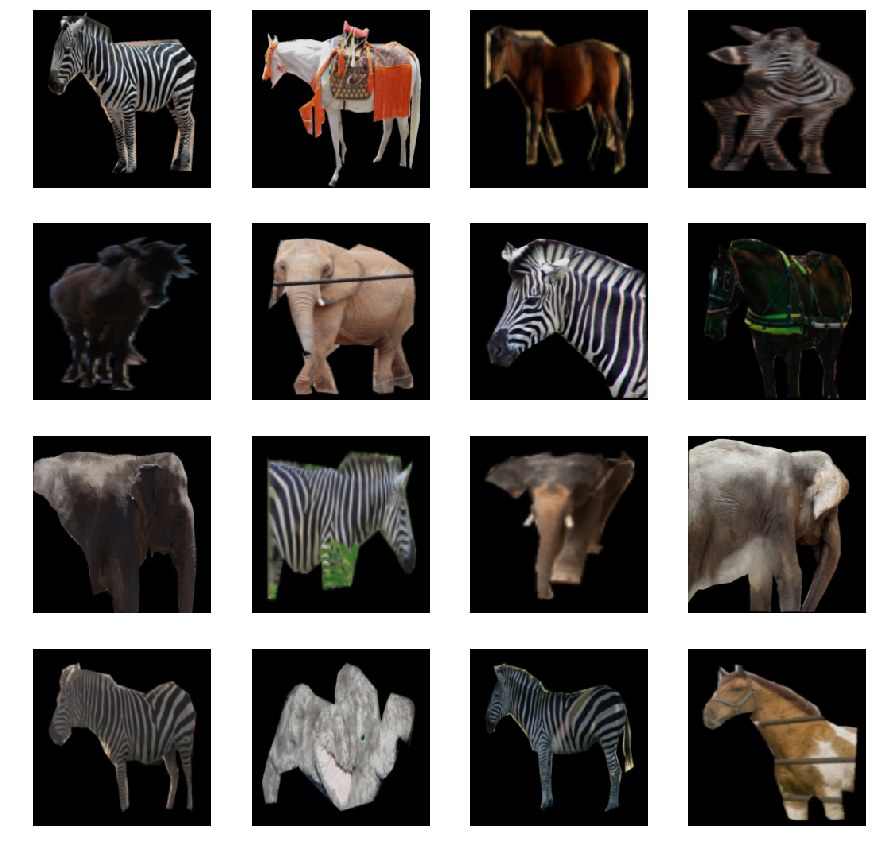

In [11]:
for im, mask in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

15236.985
14421.371
11558.65
22126.709
10742.67
19598.572
10997.486
21047.482
10649.491
14219.956
18685.639
21649.33
18534.96
15651.818
21076.791
24870.713


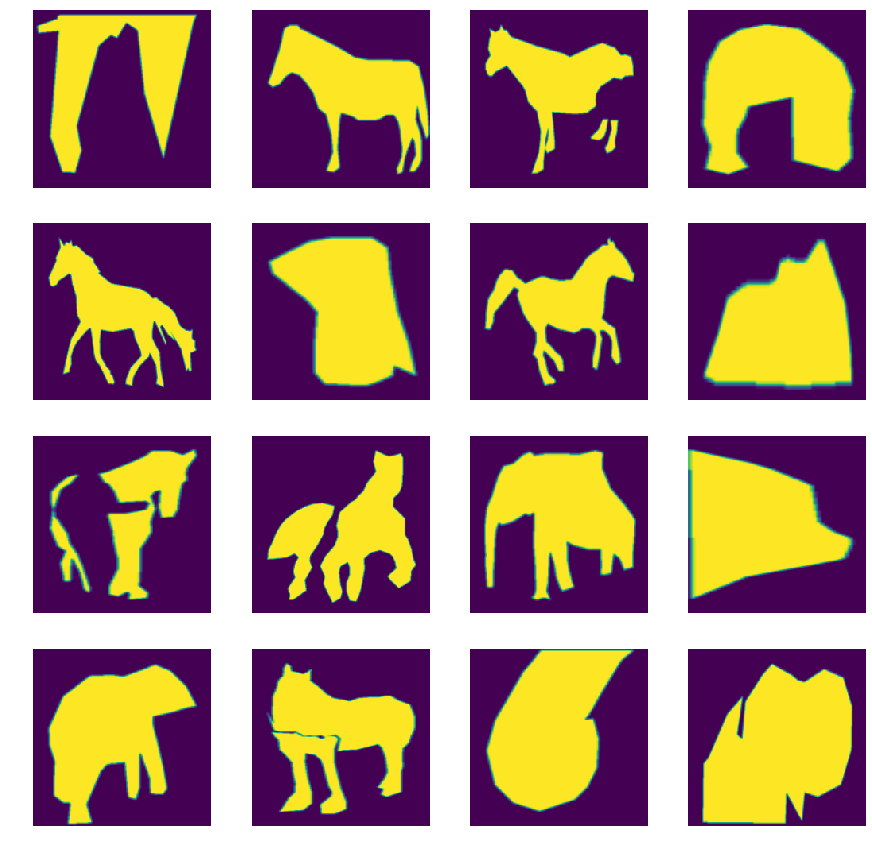

In [12]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    
    for image in mask:
        print(np.sum(image.numpy()[0]))
#         print(image.numpy()[0])
#         print(image.numpy()[0].shape)
        axarr[i, j].imshow(image.numpy()[0])
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

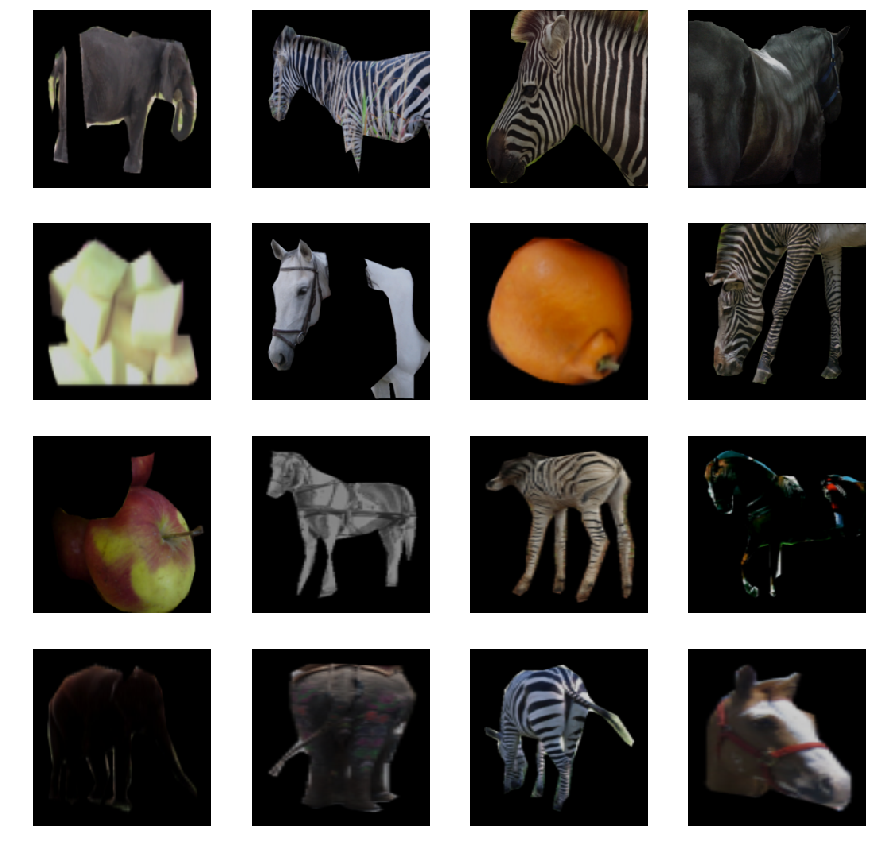

In [13]:
f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    im = np.multiply(im,mask)
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

In [14]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [15]:
from torch import nn

In [16]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [17]:
n_batches

69

In [18]:

#first model
#encoder: four conv layers 3-16-32-64-128-FC
#decoder: four deconv layers FC-128-64-32-16-3
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

class EmbeddingModel(nn.Module):
    def __init__(self, in_channels, embedding_size=128):
        super().__init__()
        rn = tv.models.resnet18()
        self.inp = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.backbo
        self.backbone= nn.Sequential(*list(rn.children())[1:-2])
        self.out1 = nn.AdaptiveAvgPool2d(1)
                     
        self.out2 = nn.Linear(512, embedding_size)
    def forward(self, x):
        x = self.inp(x)
        x = self.backbone(x)
        x = self.out1(x).contiguous().view(x.shape[0],-1)
        x = F.tanh(self.out2(x))
        #print(x.shape)
        return x
#         print(rn(torch.))


class Decoder(nn.Module):
    def __init__(self, IMAGE_SIZE):

        super(Decoder, self).__init__()
        self.image_dim = IMAGE_SIZE # a 28x28 image corresponds to 4 on the FC layer, a 64x64 image corresponds to 13
                            # can calculate this using output_after_conv() in utils.py
        self.latent_dim = 128
        
        self.del1_size = int(IMAGE_SIZE / 32)
        self.del2_size = int(self.image_dim / 16)
        #print(int(self.image_dim / 32))
        #print(self.del1_size)
        self.decoder_fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 1000),
            nn.Tanh(),
            nn.BatchNorm1d(1000)
        )
        self.decoder_fc2 = nn.Sequential(
            nn.Linear(1000, 512*self.del1_size*self.del1_size),
            nn.Tanh(),
            nn.BatchNorm1d(512*self.del1_size*self.del1_size)
        )
        self.decoder_l1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1),
            #nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),
            #nn.MaxUnpool2d(3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            #nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            #nn.MaxUnpool2d(3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            #nn.MaxUnpool2d(3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        #self.m1 = nn.MaxPool2d(3, stride=2)
        self.decoder_l4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
            #nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            #nn.MaxUnpool2d(3, stride=2)
        )
        self.decoder_l5 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        x_hat = self.decoder_fc1(z)
        x_hat = self.decoder_fc2(x_hat)
        x_hat = x_hat.view(-1, 512, self.del1_size, self.del1_size)

        x_hat = self.decoder_l1(x_hat)
        x_hat = self.decoder_l2(x_hat)
        
        x_hat = self.decoder_l3(x_hat)
        
        x_hat = self.decoder_l4(x_hat)
        
        x_hat = self.decoder_l5(x_hat)

        return x_hat
    
class Embdding_128(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(Embdding_128, self).__init__()

        self.encoder = EmbeddingModel(3)
        self.decoder = Decoder(IMAGE_SIZE)
        
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    def encode(self, x):
        #x = x.unsqueeze(0)
        z, x_hat = self.forward(x)

        return z

In [20]:
def deTanh(x):
    return x.add(1).mul(0.5)
def Tanhize(x):
    return x.mul(2).add(-1)

In [ ]:
model = model_emb(IMAGE_SIZE)
if cuda:
    model.cuda()
num_epochs = 10000
model = nn.DataParallel(model)
model.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(cocoloader):
        if cuda:
            x = Tanhize(Variable(images).cuda())
        else:
            x = Tanhize(Variable(images))

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        z, x_hat = model(x)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        if (i + 1) % 30 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    i + 1,
                    n_batches,
                    loss.data,
                    loss.data,
                    0,
                    0)
            )

    # Save real images once
#     import pdb
#     pdb.set_trace()
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 3, 224, 224) # reshape
        save_image(images.data, './Experiments/3_animals_2_fruit/obj_data/real_images.png')
    fake_images = deTanh(x_hat)
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, 28, 28) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    if epoch % 100 == 0:
        save_image(fake_images.data, './Experiments/3_animals_2_fruit/obj_data/fake_images-%0.3d.png' %(epoch + 1))

    # Save the trained parameters 
    if epoch % 1000 == 0:
        torch.save(model.state_dict(), './Experiments/3_animals_2_fruit/obj_weight/weight_' + str(epoch) + '.pkl')
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        

Epoch [0/10000], Step[30/69], d_loss: 0.4489, g_loss: 0.4489, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [0/10000], Step[60/69], d_loss: 0.2346, g_loss: 0.2346, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1/10000], Step[30/69], d_loss: 0.1591, g_loss: 0.1591, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1/10000], Step[60/69], d_loss: 0.1279, g_loss: 0.1279, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2/10000], Step[30/69], d_loss: 0.1029, g_loss: 0.1029, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2/10000], Step[60/69], d_loss: 0.0943, g_loss: 0.0943, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3/10000], Step[30/69], d_loss: 0.0915, g_loss: 0.0915, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3/10000], Step[60/69], d_loss: 0.0850, g_loss: 0.0850, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4/10000], Step[30/69], d_loss: 0.0780, g_loss: 0.0780, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4/10000], Step[60/69], d_loss: 0.0842, g_loss: 0.0842, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [5/10000], Ste